# Consinstently estimating Markov Chains with Noisy Aggregated Data

Notebook con esperimenti numerici per il seminario di fine corso di Metodi Numerici per le Catene di Markov (versione stazionaria)

In [18]:
# to avoid the pain of restarting the kernel each time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Import some basic stuff
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utilities.estimators import P_mom_stationary, P_cls_stationary
from utilities.data import generate_random_P, create_observations
from utilities.num_methods import compute_stationary_LU_GTH

In [20]:
# Fissiamo il numero di stati
S = 10

# Fissiamo il seed per la riproducibilità degli esperimenti
SEED = 42

We also define the path where to load/store data

In [21]:
SUBDIRECTORY = f'experiment_seed={SEED}'
PATH = os.path.join('data',SUBDIRECTORY)

# Let's create the directory, if it doesn't exist yet
os.makedirs(PATH, exist_ok=True)

## Experiment n° 1

For the first experiment, we want to examine the behaviour of the MoM and CLS estimators for different values of $T$ and $K$. 

In particular, we want to plot the approximation error against $T\times K$. The approximation error is measured as $\frac{1}{S^2}{\lvert\lvert\hat{P}-P\rvert\rvert}_F^2$

### Generate $P$ and $\pi$

The first thing we do is to generate the true transition matrix $P\in\mathbb{R}^{S\times S}$.

Just like the authors, we choose $S=10$, and each row will have a Dirichlet distribution: $P[i,\colon]\sim\operatorname{Dirichlet}\left(\frac{D}{S}\mathbf{e}\right)$, where $D$ is the precision parameter and $\mathbf{e}$ is the vector of all ones.  

In [22]:
# D=0.5 (like in the article)
D = 0.5
P = generate_random_P(S,'dirichlet',precision=D,rng=np.random.default_rng(SEED))

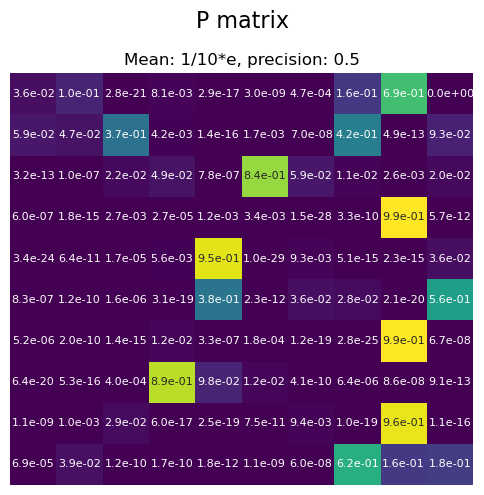

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('P matrix', fontsize=16)
plt.title(f"Mean: 1/{S}*e, precision: {D}")

sns.heatmap(P, ax=ax, cmap='viridis', annot=True, fmt=".1e", annot_kws={"size": 8}, cbar=False, xticklabels=False, yticklabels=False)

plt.tight_layout()
plt.show()

Then we need to compute the steady-state vector $\pi$, because in the stationary case we use that as initial distribution.

As seen during the course, there are many ways to do it. Since the size of $P$ is modest, I go for a direct method.

In [24]:
# Initial distribution computation

pi_gth= compute_stationary_LU_GTH(P)
print(f"The norm of pi_gth @ (I-P) = {np.linalg.norm(pi_gth@(np.eye(S)-P))}")

# We set the initial distribution
pi_0 = pi_gth

The norm of pi_gth @ (I-P) = 6.360302297111368e-17


Let's visualize the components of the invariant distribution $\pi$. Its $i$-th component is related to the probability of having observations in state $i$ for the initial distribution

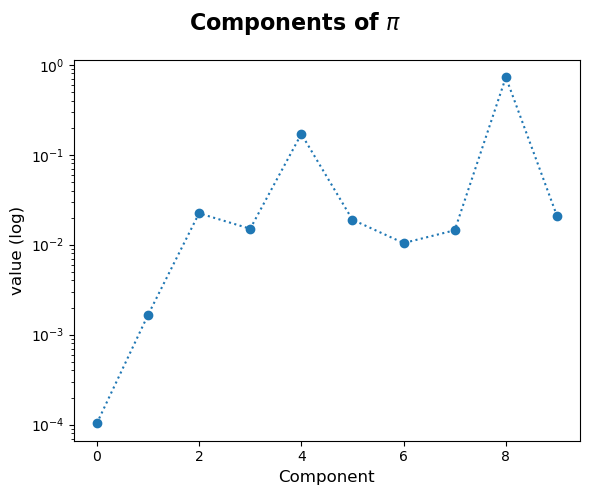

In [25]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
fig.suptitle(r"Components of $\pi$", fontsize=16, fontweight='bold')

ax.plot(pi_0, linestyle=':', marker='o')
ax.set_xlabel('Component', fontsize=12)
ax.set_ylabel('value (log)', fontsize=12)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

Let's save the transition matrix and its invariant distribution, just for consistency, i.e. to make sure that we're actually using the $P$ and $\pi$ that we just produced in the next computations. This may be needed in case of partial execution of the notebook.

In [26]:
with open(os.path.join(PATH,f'P__SEED={SEED}.npy'),'wb') as file:
	np.save(file, P)

with open(os.path.join(PATH,f'pi__SEED={SEED}.npy'),'wb') as file:
	np.save(file, pi_0)

### Generate the data (i.e. simulate the Markov Chain)

Let $N\in\mathbb{N}, p\in\mathbb{R}^S$. The multinomial distribution $\mathrm{Multinomial}(N,p)$ can be intuitively explained as the outcome of $N$ independent repeated trials, each having $S$ possible outcomes, such that the outcome $i$ has probability $p_i$ of occurring. 

For example, the throw of 2 fair 20-sided dice can be modeled with a random variable $X\sim\mathrm{Multinomial}(6,\frac{1}{20}\mathbf{e})$.

In such a context, a binomial distribution with parameters $N$ (n° of trials) and $\alpha$ (probability of success) would just be $\mathrm{Multinomial}(N,(\alpha, 1-\alpha))$

**OSS**: Let $\bar{X}$ is a sample from $\mathrm{Multinomial}(N,p)$, then $\bar{X}\in\mathbb{R}^S$, and it's easy to verify that $\bar{X}_i$ is binomial of parameters $N$ and $p_i$, in fact $\bar{X}_i\sim\mathrm{Multinomial}(N,p_i)$

The function `create_observations` generates the data, and automatically adds noise to it, if specified.

The initial distribution of the population is generated by drawing $n_1\sim\mathrm{Multinomial}(N,\pi)$. $K$ independent observations are generated at the beginning.

**OSS**: We're in the (strongly) stationary setting, the initial distribution is the steady-state vector $\pi$. The idea is that $\pi_i$ is the probability of having a single observation (i.e. a single individual presence) at state $i$.

For the following timesteps, we have
$$
	n_{t+1}\sim\sum_{i=0}^S\mathrm{Multinomial}\left(n_t(i),P[i\mid\colon]\right)\quad\forall\, t\in[T-1]
$$
The idea is that at timestep $t$ there are $n_t(i)$ members of the population, each will move to another state according to $P[i\mid\colon]$ in the next timestep. 

Again, $K$ independent observations can be generated by the function.

**OSS**: Let `n_array, y_array, A = create_observations(...)` 

Then `n_array` and `y_array` are `np.ndarray`s of shape $T\times K\times S$. 

They can be thought as lists of length $T$ in which the item at position $t\in\{0,\dots,T-1\}$ is a $K\times S$ `np.ndarray` that contains the $K$ observations for timestep $t+1$.

Instead, `A` is a $S$ by $S$ `np.ndarray`

We're ready

Let's start by defining the **parameters range**

In [27]:
# choice of the error's distribution parameters
alpha = [1, 0.5, 0.25]
variance = [0, 1, 5]

# ranges
T_range = [10**k for k in range(1,5)]	#range(1,3)
K_range = [1, 2, 5, 10, 20, 50]			#[1, 5, 20, 50]

# other parameters
n_reps = 10
N = 100

Let's start by **loading** the transition matrix and its invariant distribution. Just for safety (and good practice I guess)

In [28]:
with open(os.path.join(PATH,f'P__SEED={SEED}.npy'),'rb') as file:
	P = np.load(file)

with open(os.path.join(PATH,f'pi__SEED={SEED}.npy'),'rb') as file:
	pi_0 = np.load(file)

Since the **data creation** is an expensive process, let's do it in a separate cell.

In [29]:
from utilities.data import return_subdir_name, save_observation

from itertools import product
from tqdm import tqdm

prod = product(T_range, K_range, range(len(alpha)), ['gaussian','binomial'])
for T, K, i, noise_type in tqdm(prod):
	# Get parameter, distinguishing the two cases
	parameter = np.sqrt(variance[i]) if noise_type=='gaussian' else alpha[i]
	
	# Create subdirectory name according to a standard
	subdir_name = return_subdir_name(T=T, K=K, S=S, N=N,
								  noise_type=noise_type,
								  parameter=parameter)
	# Create the path of the subdirectory in which the arrays corresponding to
	# the given configurations of parameters have to be stored
	subdir_path = os.path.join(PATH,'observations',subdir_name)

	# Invariant: the noisy and original observations are either both present
	# or not present.
	# We check that the subdirectory doesn't exist, or that it exists but is empty
	if not os.path.exists(subdir_path) or not os.listdir(subdir_path):
		os.makedirs(subdir_path, exist_ok=True)

		# Create the n_reps observations to fill the folder right away
		for rep in range(n_reps):
			# Create name of the file in which to save the arrays
			n_filename = f"n_t_arr__repetition={rep}"
			y_filename = f"y_t_arr__repetition={rep}"
			# This is "complicazione affari semplici"
			# At the very least let's save one copy instead of n_reps
			par_name_val = "stdev" if noise_type=='gaussian' else 'alpha'
			A_filename = f"A_noise_type={noise_type}_{par_name_val}={parameter}"
		
			n_t_array, y_t_array, A = create_observations(
											T=T, K=K, N=N,
											P=P, pi_0=pi_0,
											noise_type=noise_type, 
											parameter=parameter)

			save_observation(array=n_t_array,
							filename = n_filename,
							path=subdir_path)
			
			save_observation(array=y_t_array,
							filename = y_filename,
							path=subdir_path)
			
			save_observation(array=A,
							filename=A_filename,
							path=subdir_path)
	else:
		# In case the directory already exists and has files inside, 
		# we just check that there's the correct number of them
		num_files = len(os.listdir(subdir_path))
		assert num_files == 2*n_reps+1, f"Error: in {subdir_name} there are {num_files} files, there should be 2*n_+1 reps = {2*n_reps}"


144it [00:00, 1696.71it/s]


### Computation of the estimators

We now compute the estimators and their error, using the data we stored.

In [30]:
from utilities.data import load_observation

gauss_errors, binomial_errors = [], []
zero_division_configurations = []

def error_computation(M:np.ndarray) -> float: 
    sqnorm = (np.linalg.norm(M-P,'fro')**2)
    return sqnorm/(S**2)

prod = product(T_range, K_range, range(len(alpha)), ['gaussian','binomial'])
for T, K, i, noise_type in tqdm(prod):
    # Get parameter, distinguishing the two cases
	parameter = np.sqrt(variance[i]) if noise_type=='gaussian' else alpha[i]
	# Create a dictionary to store the data, with parameters value
	dict_entry = {
		'noise_type': noise_type,
		'TxK': T*K,
	}
	if noise_type == 'gaussian':
		dict_entry['stdev'] = parameter
	else:
		dict_entry['alpha'] = parameter

	# Get the name of the subdirectory relative to the current params config
	obs_subdir_name = return_subdir_name(T=T, K=K, S=S, N=N,
								  noise_type=noise_type,
								  parameter=parameter)
	# Get the path of the subdirectory
	obs_subdir_path = os.path.join(PATH,'observations',obs_subdir_name)

	# We check that the path exists and has data.
	# This could be done more elegantly with exceptions maybe, but should be ok
	if not os.path.exists(obs_subdir_path) or not os.listdir(obs_subdir_path):
		print(f"The directory {obs_subdir_path} is empty or doesn't exist")
		print("Please generate the data by running the cell above")
		break

	# Just like the author, the computations are repeated 
	# (of course we already have the data)
	for rep in range(n_reps):
		# Get name of the file in which the arrays are saved
		n_filename = f"n_t_arr__repetition={rep}"
		y_filename = f"y_t_arr__repetition={rep}"
		par_name_val = "stdev" if noise_type=='gaussian' else 'alpha'
		A_filename = f"A_noise_type={noise_type}_{par_name_val}={parameter}"

		n_t_array = load_observation(filename=n_filename, path=obs_subdir_path)
		y_t_array = load_observation(filename=y_filename, path=obs_subdir_path)
		A_t_arr = load_observation(filename=A_filename, path=obs_subdir_path)

		with warnings.catch_warnings(record=True) as w:
			# I'm being lazy and catching all warnings, but all I really care is 
			# RuntimeWarning: invalid value encountered in divide
			warnings.simplefilter("always")

			# method of moments estimator
			P_mom, mu_hat, _ = P_mom_stationary(y_array=y_t_array, A=A_t_arr, N=N)
			# conditional least squares estimator
			P_cls = P_cls_stationary(y_array=y_t_array)

			# In case or zero divisions during P_mom computation, err=np.nan
			# Thus, something may be made about it
			err_mom = error_computation(P_mom)
			err_cls = error_computation(P_cls)
			
			dict_entry[f'error_MoM_{rep}'] = err_mom
			dict_entry[f'error_CLS_{rep}'] = err_cls

			# Store the error, with its parameters, into the list
			if noise_type=='gaussian':
				gauss_errors.append(dict_entry)
			else:
				binomial_errors.append(dict_entry)

			if w:
				bad_config = {
					'T':T,
					'K':K,
					'noise_type':noise_type,
					'n_t': n_t_array,
					'y_t': y_t_array,
					'A_t': A_t_arr,
					'parameter': parameter,
					'P_mom': P_mom,
					'mu_hat': mu_hat
				}
				zero_division_configurations.append(bad_config)
			
			


7it [00:00, 64.78it/s]

144it [00:24,  5.95it/s]


#### `NaN`s checking

There is a problem with the `NaN`s, and I don't think we'll ever get rid of them.

The problem is that sometimes there are no individuals in a certain state, at all. Thus the sample mean $m$ has a zero component, and in the formula for the estimator
$$
	\hat{P}_{\textup{MoM}}:=\operatorname{Diag}(\hat{\mu})^{-1}\left(\frac{1}{N}\hat{\Sigma}+\hat{\mu}\cdot\hat{\mu}^{\top}\right)
$$
there is a division by zero.

Of course, this is unlikely. The factor that make it more likely are: 
- No noise
- Few total timesteps $T$, few repeated observations $K$
- $\pi_i$ is very small

Let's check these claims

In [31]:
bad_outcomes_df = pd.DataFrame(zero_division_configurations)

bad_gaussian_df = bad_outcomes_df[bad_outcomes_df['noise_type'] == 'gaussian']
bad_binomial_df = bad_outcomes_df[bad_outcomes_df['noise_type'] == 'binomial']

##### Which noise is more problematic?

Firstly, let's see which noise model yielded the most divisions by zero

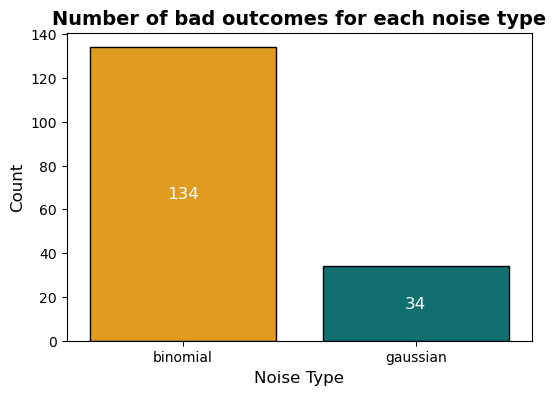

In [32]:
# Count the number of rows for each noise type
noise_counts = bad_outcomes_df['noise_type'].value_counts()

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=noise_counts.index,  y=noise_counts.values, 
			palette=['orange', 'teal'], edgecolor='black',
			legend=False, hue=noise_counts.index,
			ax=ax)

# Display the absolute number in the middle of each bar
for i in range(len(noise_counts)):
	ax.text(i, noise_counts.values[i] / 2, str(noise_counts.values[i]), ha='center', va='center', fontsize=12, color='white')

ax.set_xlabel('Noise Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Number of bad outcomes for each noise type', fontsize=14, fontweight='bold')
plt.show()

Estimators with `NaN` components are disproportionately due to binomial rather than gaussian noise. We'll return on this point when discussing the parameters.

##### Zero divisions?

First thing first, let's give evidence that indeed this is due to a zero division (I know it because I read the alerts raised by NumPy, but their hidden in this version of the code).

Is it true that all the computed means $\hat{m}$ have a zero component somewhere?

In [33]:
all_mu_have_a_zero = bad_outcomes_df['mu_hat'].apply(lambda arr: np.any(arr == 0)).all()

if all_mu_have_a_zero:
	print("All the mean vectors (computed from the noisy observations, mind you) have a zero somewhere")
else:
	print("At least one mean vector has all nonzero components")

All the mean vectors (computed from the noisy observations, mind you) have a zero somewhere


##### Ranges for $T$ and $K$

We remind that the means are taken across the $T$ (temporal) and $K$ (repetitions) dimension. So, if there is a zero in component $i$ of the mean vector, this means (ignoring noise for now, but we'll come back to it later) that all of the addends are zero.

Of course, this is really unlikely, unless the addends are few.

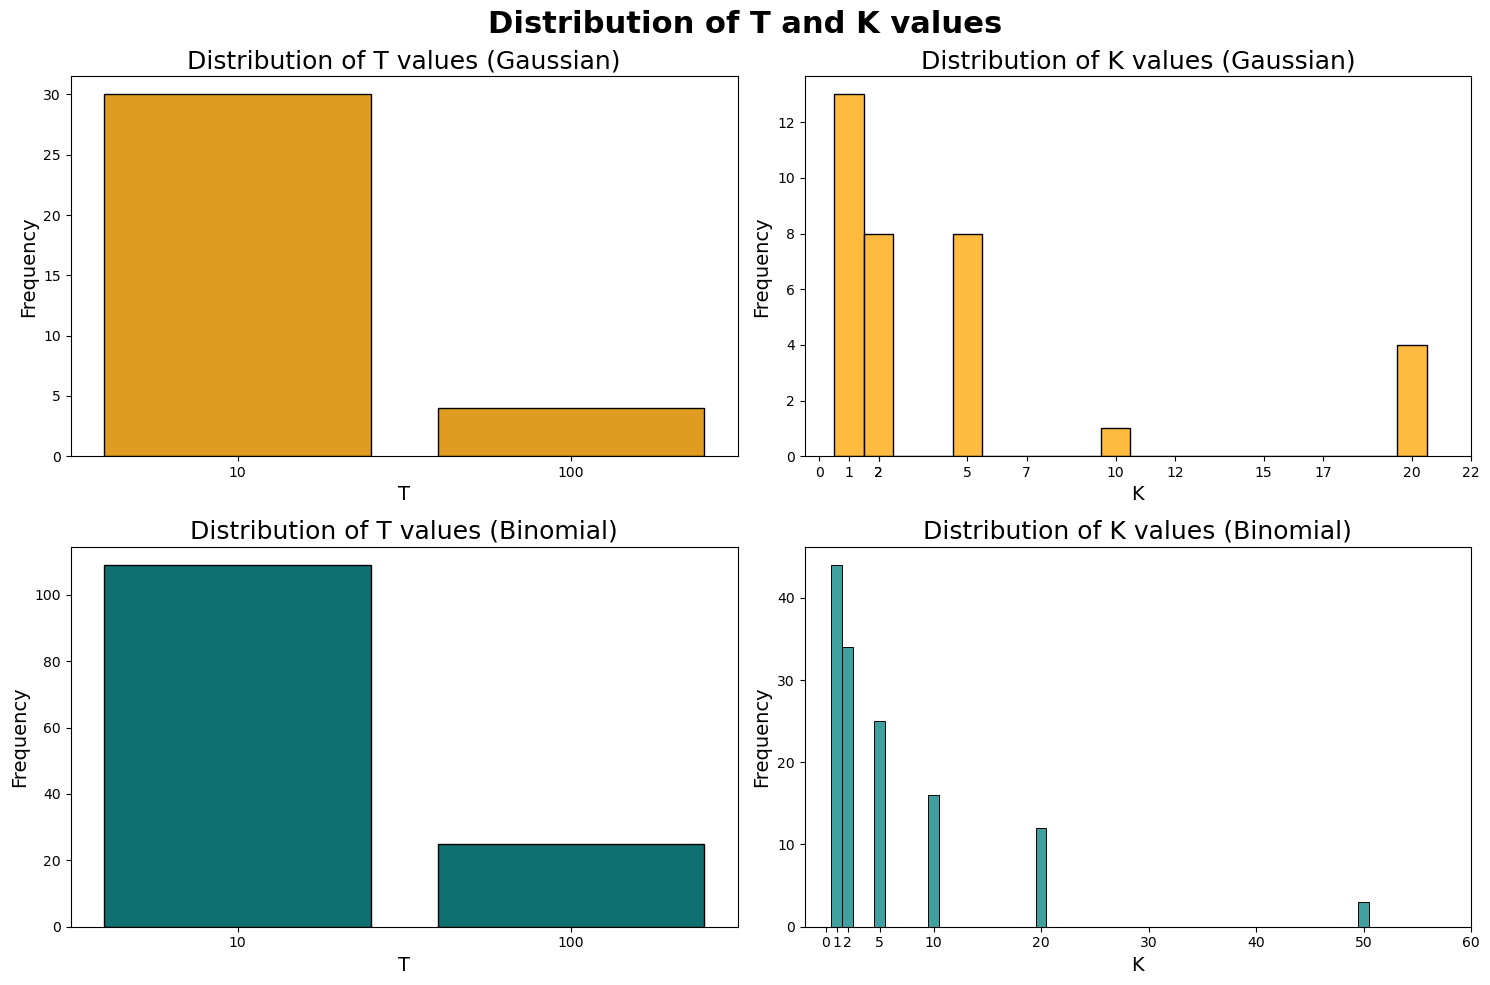

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Distribution of T and K values", fontweight='bold', fontsize=22)

# Plot for bad_gaussian_df T values
sns.barplot(x=bad_gaussian_df['T'].value_counts().index, 
			y=bad_gaussian_df['T'].value_counts().values, 
			ax=ax[0, 0], 
			color='orange', edgecolor='black')
#sns.histplot(bad_gaussian_df['T'], ax=ax[0,0], color='orange', discrete=True)
ax[0, 0].set_title('Distribution of T values (Gaussian)', fontsize=18)
ax[0, 0].set_xlabel('T', fontsize=14)
ax[0, 0].set_ylabel('Frequency', fontsize=14)
#xticks = sorted(set(ax[0, 0].get_xticks()[:-1]).union(set(bad_gaussian_df['T'].unique())))
#ax[0, 0].set_xticks(xticks)

# Plot for bad_gaussian_df K values
sns.histplot(bad_gaussian_df['K'], ax=ax[0, 1], color='orange', discrete=True)
ax[0, 1].set_title('Distribution of K values (Gaussian)', fontsize=18)
ax[0, 1].set_xlabel('K', fontsize=14)
ax[0, 1].set_ylabel('Frequency', fontsize=14)
xticks = sorted(set(ax[0, 1].get_xticks()[1:]).union(set(bad_gaussian_df['K'].unique())))
ax[0, 1].set_xticks([int(x) for x in xticks])

# Plot for bad_binomial_df T values
sns.barplot(x=bad_binomial_df['T'].value_counts().index, 
			y=bad_binomial_df['T'].value_counts().values, 
			ax=ax[1, 0], 
			color='teal', edgecolor='black')
ax[1, 0].set_title('Distribution of T values (Binomial)', fontsize=18)
ax[1, 0].set_xlabel('T', fontsize=14)
ax[1, 0].set_ylabel('Frequency', fontsize=14)
#xticks = sorted(set(ax[1, 0].get_xticks()[:-1]).union(set(bad_binomial_df['T'].unique())))
#ax[1, 0].set_xticks(xticks)

# Plot for bad_binomial_df K values
sns.histplot(bad_binomial_df['K'], ax=ax[1, 1], color='teal', discrete=True)
ax[1, 1].set_title('Distribution of K values (Binomial)', fontsize=18)
ax[1, 1].set_xlabel('K', fontsize=14)
ax[1, 1].set_ylabel('Frequency', fontsize=14)
xticks = sorted(set(ax[1, 1].get_xticks()[1:]).union(set(bad_binomial_df['K'].unique())))
ax[1, 1].set_xticks(xticks)

plt.tight_layout()
plt.show()

We notice that for both noise models the observations that yield division by zero have low values of $T$. 

This is consistent with the hypothesis that by evolving for more timesteps, sooner or later someone will land in every state. Conversely, if the timesteps are few it is increasingly likely that there are states without individuals throughout the whole simulation.

Likewise, the number of repetitions $K$ is low, and a similar reasoning as before can be made. When the repetitions are many, it's less likely to encounter states without individuals in them.

##### Noise parameters check

Let's start by seeing what were the values of the noise parameters corresponding to zero divisions

In [35]:
print(f"Unique values for the standard deviation that lead to zero division in the gaussian noise case: {bad_gaussian_df['parameter'].unique()}")
print(f"Unique values for the standard deviation that lead to zero division in the binomial noise case: {bad_binomial_df['parameter'].unique()}")

Unique values for the standard deviation that lead to zero division in the gaussian noise case: [0.]
Unique values for the standard deviation that lead to zero division in the binomial noise case: [1.   0.5  0.25]


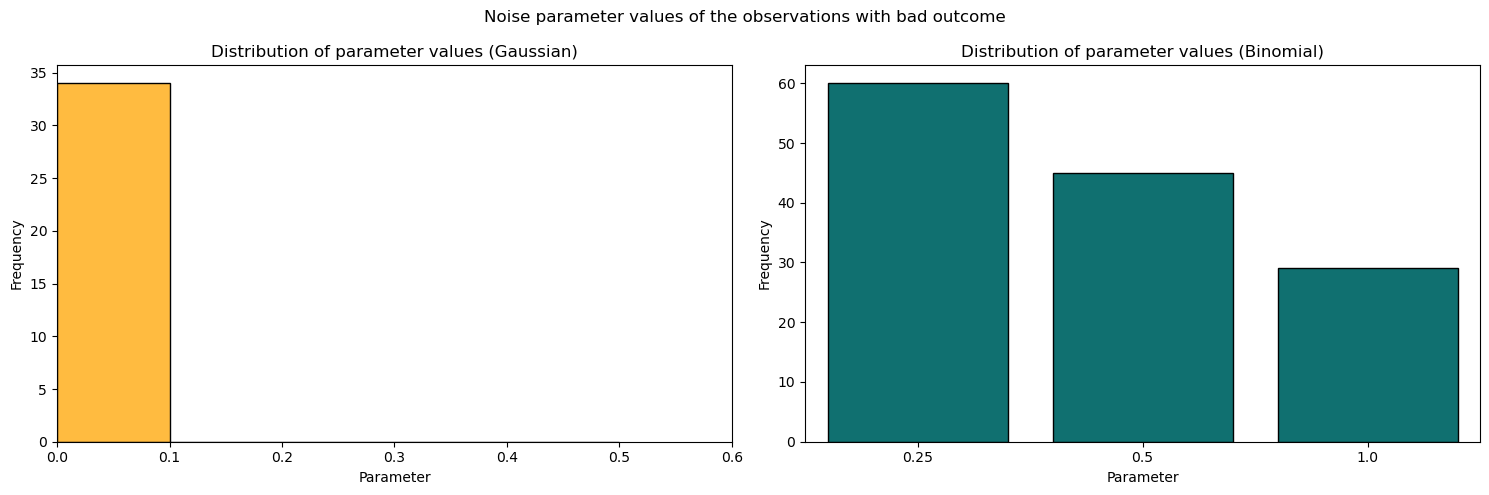

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Noise parameter values of the observations with bad outcome")

#sns.barplot(x=bad_gaussian_df['parameter'].value_counts().index, 
#			y=bad_gaussian_df['parameter'].value_counts().values, 
#			color='orange', edgecolor='black', ax=ax[0])
sns.histplot(bad_gaussian_df['parameter'], color='orange', bins=10, ax=ax[0])
ax[0].set_xlim(left=0)
ax[0].set_title('Distribution of parameter values (Gaussian)')
ax[0].set_xlabel('Parameter')
ax[0].set_ylabel('Frequency')
xticks = sorted(set(ax[0].get_xticks()).union(set(bad_gaussian_df['parameter'].unique())))
ax[0].set_xticks(xticks)

sns.barplot(x=bad_binomial_df['parameter'].value_counts().index, 
			y=bad_binomial_df['parameter'].value_counts().values, 
			color='teal', edgecolor='black', ax=ax[1])
ax[1].set_title('Distribution of parameter values (Binomial)')
ax[1].set_xlabel('Parameter')
ax[1].set_ylabel('Frequency')
#xticks = sorted(set(ax[1].get_xticks()).union(set(bad_binomial_df['parameter'].unique())))
#ax[1].set_xticks(xticks)

plt.tight_layout()
plt.show()

For the gaussian noise, we only get divisions by zero when the variance is zero, i.e. no noise is added and $y_t=n_t$. It makes sense that $y_t(i)\ne 0$ in the general case, because the probability of summing exactly zero (i.e. drawing $\epsilon_t=0$) to $n_t(i)$ is zero.

**OSS**: when the observations are not noisy, $\hat{P}_{\textup{MoM}}$ is stochastic, but there is the risk of not obtaining anything useful (i.e. encounter divisions by zero)

Let's turn to the binomial noise. 

In the case $\alpha=1$ then there's no noise and $n_t=y_t$, so for this case the divisions by zero are "inherited" from the original aggregated data (no individuals in one of the state throughout the all evolution, for all repetitions).

However, when the detection probability $\alpha$ is small, there is the chance that $n_t(i)$ is small and $y_t(i)=0$, as $\mathbb{P}\left(y_t(i)=0\mid n_t(i)\right)=(1-\alpha)^{n_t(i)}$.

This is why most observations that give divisions by zero have gaussian noise.

### Let's move on

Let's create some dataframes and compute the means beforehand

In [37]:
# Create dataframes
gauss_df = pd.DataFrame(gauss_errors)
binom_df = pd.DataFrame(binomial_errors)

# Compute the means of the repeated observations
gauss_df['mean_MoM'] = gauss_df[[f'error_MoM_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
gauss_df['mean_CLS'] = gauss_df[[f'error_CLS_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
binom_df['mean_MoM'] = binom_df[[f'error_MoM_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
binom_df['mean_CLS'] = binom_df[[f'error_CLS_{i}' for i in range(n_reps)]].mean(axis=1).dropna()

Let's peek at what we've got

In [38]:
gauss_df.head()

,noise_type,TxK,stdev,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,...,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9,mean_MoM,mean_CLS
0,gaussian,10,0.0,NaN,51.552032,NaN,2.765702,NaN,0.737062,NaN,...,NaN,3.190879,NaN,1.183006,NaN,0.323661,0.311205,1.903072,0.311205,6.520304
1,gaussian,10,0.0,NaN,51.552032,NaN,2.765702,NaN,0.737062,NaN,...,NaN,3.190879,NaN,1.183006,NaN,0.323661,0.311205,1.903072,0.311205,6.520304
2,gaussian,10,0.0,NaN,51.552032,NaN,2.765702,NaN,0.737062,NaN,...,NaN,3.190879,NaN,1.183006,NaN,0.323661,0.311205,1.903072,0.311205,6.520304
3,gaussian,10,0.0,NaN,51.552032,NaN,2.765702,NaN,0.737062,NaN,...,NaN,3.190879,NaN,1.183006,NaN,0.323661,0.311205,1.903072,0.311205,6.520304
4,gaussian,10,0.0,NaN,51.552032,NaN,2.765702,NaN,0.737062,NaN,...,NaN,3.190879,NaN,1.183006,NaN,0.323661,0.311205,1.903072,0.311205,6.520304


In [39]:
binom_df.head()

,noise_type,TxK,alpha,error_MoM_0,error_CLS_0,error_MoM_1,error_CLS_1,error_MoM_2,error_CLS_2,error_MoM_3,...,error_MoM_6,error_CLS_6,error_MoM_7,error_CLS_7,error_MoM_8,error_CLS_8,error_MoM_9,error_CLS_9,mean_MoM,mean_CLS
0,binomial,10,1.0,NaN,174.184465,NaN,1.866431,NaN,2.551102,NaN,...,NaN,0.579173,0.30231,0.875159,NaN,0.731782,NaN,41.624307,0.30231,28.209579
1,binomial,10,1.0,NaN,174.184465,NaN,1.866431,NaN,2.551102,NaN,...,NaN,0.579173,0.30231,0.875159,NaN,0.731782,NaN,41.624307,0.30231,28.209579
2,binomial,10,1.0,NaN,174.184465,NaN,1.866431,NaN,2.551102,NaN,...,NaN,0.579173,0.30231,0.875159,NaN,0.731782,NaN,41.624307,0.30231,28.209579
3,binomial,10,1.0,NaN,174.184465,NaN,1.866431,NaN,2.551102,NaN,...,NaN,0.579173,0.30231,0.875159,NaN,0.731782,NaN,41.624307,0.30231,28.209579
4,binomial,10,1.0,NaN,174.184465,NaN,1.866431,NaN,2.551102,NaN,...,NaN,0.579173,0.30231,0.875159,NaN,0.731782,NaN,41.624307,0.30231,28.209579


And finally plot it

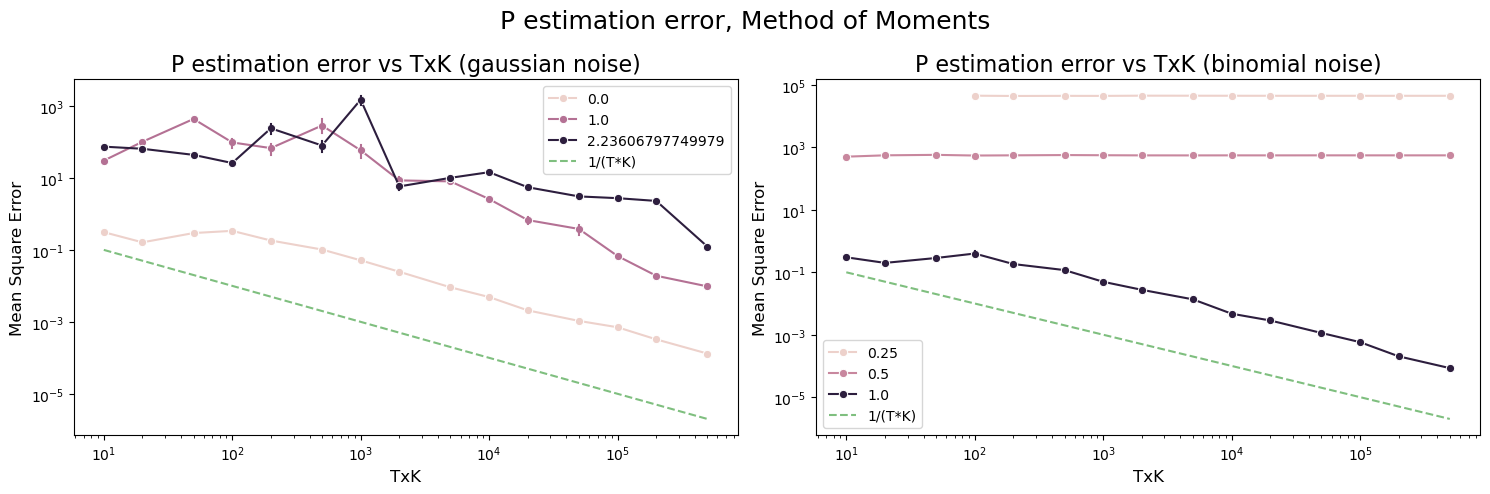

In [40]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(15,5))

for i, noise_type in enumerate(['gaussian', 'binomial']):
    data_che_uso = gauss_df if noise_type == 'gaussian' else binom_df
    small_df = data_che_uso.copy()
    small_df.drop(columns=[f'error_CLS_{i}' for i in range(n_reps)],inplace=True)
    hue_val = 'stdev' if noise_type == 'gaussian' else 'alpha'
    # Plot the errors
    sns.lineplot(data=small_df, x='TxK', y='mean_MoM', 
                 err_style='bars', errorbar='ci',
                 hue=hue_val, ax=ax[i], marker='o')
    # Plot 1/(T*K)
    ax[i].plot(data_che_uso['TxK'], 1/data_che_uso['TxK'], 
               linestyle='--', color='green', alpha = 0.5,
               label='1/(T*K)')
    
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('TxK', fontsize=12)
    ax[i].set_ylabel('Mean Square Error', fontsize=12)
    ax[i].set_title(f'P estimation error vs TxK ({noise_type} noise)', fontsize=16)
    ax[i].legend()

fig.suptitle('P estimation error, Method of Moments', fontsize=18)
plt.tight_layout()
plt.show()

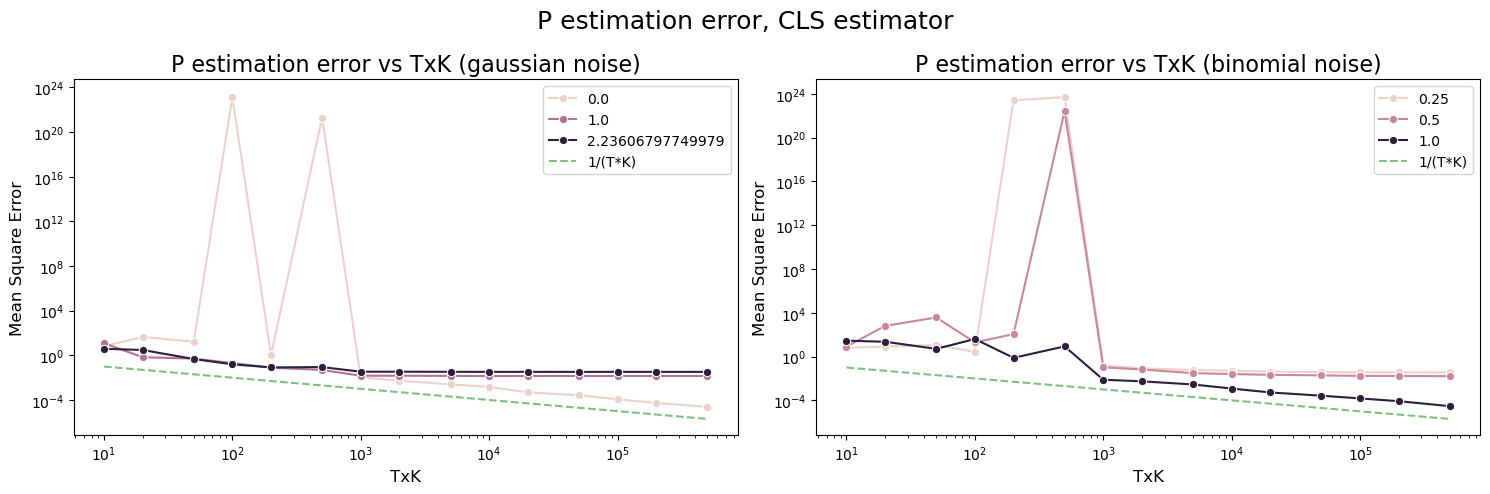

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('P estimation error, CLS estimator', fontsize=18)

for i, noise_type in enumerate(['gaussian', 'binomial']):
    data_che_uso = gauss_df if noise_type == 'gaussian' else binom_df
    small_df = data_che_uso.copy()
    small_df.drop(columns=[f'error_MoM_{i}' for i in range(n_reps)],inplace=True)
    hue_val = 'stdev' if noise_type == 'gaussian' else 'alpha'
    # Plot the errors
    sns.lineplot(data=small_df, x='TxK', y='mean_CLS', 
                 err_style='bars', errorbar='ci',
                 hue=hue_val, ax=ax[i], marker='o')
    # Plot 1/(T*K)
    ax[i].plot(data_che_uso['TxK'], 1/data_che_uso['TxK'], 
               linestyle='--', color='green', alpha = 0.5,
               label='1/(T*K)')
    
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('TxK', fontsize=12)
    ax[i].set_ylabel('Mean Square Error', fontsize=12)
    ax[i].set_title(f'P estimation error vs TxK ({noise_type} noise)', fontsize=16)
    ax[i].legend()

plt.tight_layout()
plt.show()

## Experiment n° 3

For the third experiment, we assess the impact of the population size $N$.

In [42]:
N_range = [10**k for k in range(0,5)]
T = 10**5
K = 20

n_reps = 10

In [ ]:
N_errors = []

for N in tqdm(N_range):
    dict_entry = {'N':N}

    for rep in range(n_reps):
        n_array, _, _ = create_observations(T=T,N=N,K=K,pi_0=pi_0,stationary=True)

        P_mom = P_mom_stationary(y_array = n_array, A = np.eye(S), N=N)
        P_cls = P_cls_stationary(y_array = n_array)

        dict_entry[f'error_MoM_{rep}'] = error_computation(P_mom)
        dict_entry[f'error_CLS_{rep}'] = error_computation(P_cls)

    N_errors.append(dict_entry)

In [ ]:
N_df = pd.DataFrame(N_errors)
N_df.head()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

for i, estimator in enumerate(['MoM', 'CLS']):
    y = N_df[[f'error_{estimator}_{i}' for i in range(n_reps)]].mean(axis=1).dropna()
    sns.lineplot(data=N_df, x='N', y=y, ax=ax[i])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('N', fontsize=14)
    ax[i].set_ylabel('Mean Square Error', fontsize=14)
    ax[i].set_title(f'P estimation MSE vs N ({estimator} estimator)', fontsize=16)

fig.suptitle('P estimation error', fontsize=18)
plt.show()

We can see that the error has the same order of magnitude, independently from $N$. This is in accordance with what's been found by the authors.